In [1]:
import pyspark
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark PCA example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/21 23:14:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/21 23:14:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/21 23:14:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
df_origin = spark.read.json("data/iris.json")

In [3]:
df_origin.show(5)
df_origin.printSchema()

+-----------+------------+-----------+------------+-----------+
|      class|petal_length|petal_width|sepal_length|sepal_width|
+-----------+------------+-----------+------------+-----------+
|Iris-setosa|         1.4|        0.2|         5.1|        3.5|
|Iris-setosa|         1.4|        0.2|         4.9|        3.0|
|Iris-setosa|         1.3|        0.2|         4.7|        3.2|
|Iris-setosa|         1.5|        0.2|         4.6|        3.1|
|Iris-setosa|         1.4|        0.2|         5.0|        3.6|
+-----------+------------+-----------+------------+-----------+
only showing top 5 rows

root
 |-- class: string (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)



In [4]:
df_origin.describe().show()

+-------+--------------+------------------+------------------+------------------+-------------------+
|summary|         class|      petal_length|       petal_width|      sepal_length|        sepal_width|
+-------+--------------+------------------+------------------+------------------+-------------------+
|  count|           150|               150|               150|               150|                150|
|   mean|          null|3.7580000000000027| 1.199333333333334| 5.843333333333335|  3.057333333333334|
| stddev|          null|1.7652982332594662|0.7622376689603467|0.8280661279778637|0.43586628493669793|
|    min|   Iris-setosa|               1.0|               0.1|               4.3|                2.0|
|    max|Iris-virginica|               6.9|               2.5|               7.9|                4.4|
+-------+--------------+------------------+------------------+------------------+-------------------+



In [5]:
vecAssembler = VectorAssembler(inputCols=["sepal_width", "sepal_length", "petal_width", "petal_length"], \
                               outputCol="features")

In [6]:
df=vecAssembler.transform(df_origin)

In [7]:
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures",withStd=True, withMean=True)
scalerModel=scaler.fit(df)

In [8]:
df=scalerModel.transform(df)

In [9]:
def findTopPrincipalComponentNumber(data:pyspark.sql.dataframe.DataFrame=df, \
                                    featureCol:str='features',threshold:int=0.80) -> (int, int):
    df_detect=data.select(featureCol)
    df_detect_list=[]
    for i in df_detect.collect():
        df_detect_list.append(i[0].tolist())
    df_detect_np=np.array(df_detect_list)
    cov_mat = np.cov(df_detect_np.T) #Get the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) #Get list of Eigenvalues and list of Eigenvectors, 
                                                    #numbef of Eigenvalues = number of the feature columns 
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] #Sort the Eigenvalues in descending order
                                                                    #get the percentage of each Eigenvalue against 
                                                                    #sum of total eigenvalues
                                                                    #Then find number cumulative percentage from
                                                                    #first few largest eigenvalues to see threshold 
                                                                    #is crossed.  If so, you only need these few 
                                                                    #number of columns in PCA()
    cumulativePercept=0
    cumulativePerceptList=[]
    for i in var_exp:
        cumulativePercept+=i
        cumulativePerceptList.append(cumulativePercept)
        if cumulativePercept >= threshold:
            break
    return (len(cumulativePerceptList), cumulativePerceptList[-1])

In [22]:
bestK, coverPercentage=findTopPrincipalComponentNumber(data=df, featureCol='scaledFeatures', threshold=0.80)
pca = PCA(k=bestK, inputCol="scaledFeatures", outputCol="pcaFeatures")
print(f"{bestK} principal components covers the {round(coverPercentage*100,2)}% from original dataset with {len(df_origin.columns)-1} feature columns")

2 principal components covers the 95.81% from original dataset with 4 feature columns


In [11]:
pipeline = Pipeline(stages=[pca])

In [12]:
model = pipeline.fit(df)


23/05/21 23:15:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/21 23:15:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/05/21 23:15:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/05/21 23:15:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [13]:
xy = model.transform(df).select("pcaFeatures").rdd.map(lambda row: [row[0][0], row[0][1]]).collect()

In [14]:
xy[0:5]

[[-2.25714117564812, -0.47842383212490514],
 [-2.0740130151996214, 0.6718826870273563],
 [-2.3563351118061786, 0.34076642462456513],
 [-2.291706785869695, 0.5953998626815398],
 [-2.381862704416939, -0.6446756594005434]]

In [15]:
x=np.array(list(zip(*xy))[0])
y=np.array(list(zip(*xy))[1])

In [16]:
x[0:5]

array([-2.25714118, -2.07401302, -2.35633511, -2.29170679, -2.3818627 ])

In [17]:
y[0:5]

array([-0.47842383,  0.67188269,  0.34076642,  0.59539986, -0.64467566])

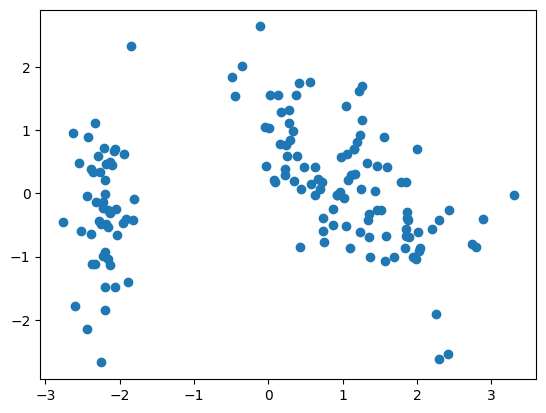

In [18]:
plt.scatter(x,y)
plt.show()

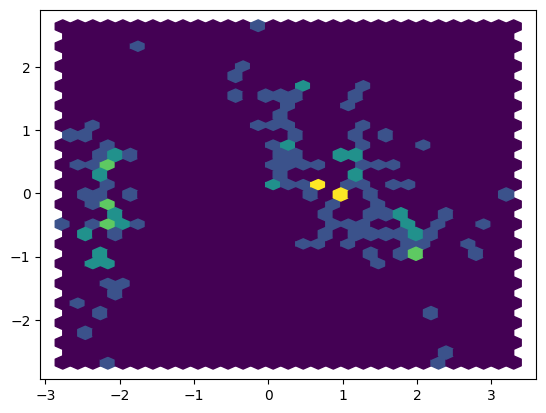

In [19]:
plt.hexbin(x,y,  gridsize=30)
plt.show()
